# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [3]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()


creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
from google.colab import files

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print 'Files in Drive:'
!ls drive/

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Construcción del conjunto de datos

In [0]:
#raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

max_num_categories = 100
train_samples_per_cat = 1000
test_samples_per_cat = 50

### Importar dataset previamente construido

In [0]:
!cp drive/data_quickdraw/train.tar.gz train.tar.gz 
!cp drive/data_quickdraw/test.tar.gz test.tar.gz 

In [10]:
!tar xzf train.tar.gz
!tar xzf test.tar.gz
!ls

datalab  drive	test  test.tar.gz  train  train.tar.gz


### Importar modelo previamente entrenado

In [9]:
!rm -rf training/
!rm -rf training_sknet/

!cp drive/data_quickdraw/training.zip training.zip
!unzip training.zip -d training/

!cp drive/data_quickdraw/training_sknet.zip training_sknet.zip
!unzip training_sknet.zip -d training_sknet/
!ls

Archive:  training.zip
   creating: training/training/
  inflating: training/training/checkpoint  
  inflating: training/training/snap-skresnet.ckpt.index  
  inflating: training/training/snap-data  
  inflating: training/training/snap-skresnet.ckpt.data-00000-of-00001  
  inflating: training/training/snap-skresnet.ckpt.meta  
Archive:  training_sknet.zip
   creating: training_sknet/training/
  inflating: training_sknet/training/checkpoint  
  inflating: training_sknet/training/snap-sknet.ckpt.data-00000-of-00001  
  inflating: training_sknet/training/snap-sknet.ckpt.index  
  inflating: training_sknet/training/snap-sknet.ckpt.meta  
datalab  test	      train	training_sknet	    training.zip
drive	 test.tar.gz  training	training_sknet.zip  train.tar.gz


### Elegimos 100 categorias al azar y las descargamos (realizar sólo una vez)

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [5]:
#!mkdir quick_draw_data
#os.chdir("/content/quick_draw_data")
!mkdir training

mkdir: cannot create directory ‘training’: File exists
datalab  training


In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)

In [9]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/donut.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/fan.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/blackberry.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/helmet.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/airplane.ndjson


In [10]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if (cat + ".ndjson").replace("\ ", " ") not in categories:
    print("falta " + cat)

8


### Se convierte la data en formato json a bitmaps de 128x128 y se guardan en formato .txt

In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 offset=0):
  
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

    
  reading_order = list(range(len(file_handles)))
          
  class_names = []  
  class_names_pairs = []
    
  for idx in reading_order:
    for pictureNum in range(observations_per_class):
      line = file_handles[idx].readline()
      ink = None
      
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")

      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      if class_name not in class_names:
        class_names.append(class_name)  
        class_names_pairs.append((idx, class_name))      
        os.system("mkdir " + output_folder + str(idx))
        print(str(idx) + ";" + class_name)

      for linea in ink:
        for idy in range(len(linea[0])-1):
          rr, cc = drawLine(linea[1][idy], linea[0][idy], linea[1][idy+1], linea[0][idy+1])
          drawing[rr, cc] = 1

      np.savetxt(output_folder + str(idx) + "/" + str(pictureNum) + ".txt", drawing, fmt="%d", delimiter=" ")

  return class_names_pairs

In [0]:
class_names_train = convert_data(".",
             train_samples_per_cat,
             "train/")

In [0]:
class_names_test = convert_data(".",
             test_samples_per_cat,
             "test/",
             train_samples_per_cat)

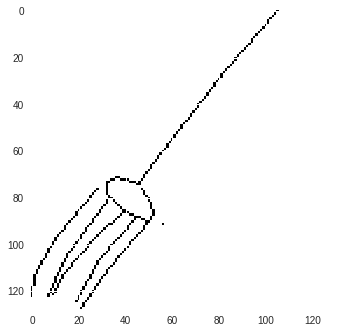

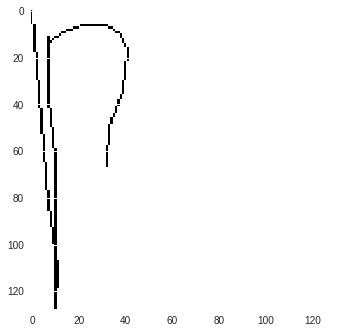

In [16]:
test_imagen = np.loadtxt("test/12/9.txt")
plt.imshow(test_imagen)
plt.show()

train_imagen = np.loadtxt("train/12/99.txt")
plt.imshow(train_imagen)
plt.show()

### Descargar Dataset

In [0]:
!tar czf train.tar.gz train/
!tar czf test.tar.gz test/
files.download('train.tar.gz') 
files.download('test.tar.gz') 

### Se crea una clase para extraer datos de entrenamiento

In [0]:
class QuickDataset():
  def __init__(self, data_path, samples_per_cat):            
    self.samples = samples_per_cat
    self.data_path = data_path + "/"    
  
  def get_batch(self, batch_size):
    x_lista = []
    y_lista = []    
    
    for _ in range(batch_size):
      cat = np.random.randint(max_num_categories)
      sample = np.random.randint(self.samples)
      
      train_input = np.loadtxt(self.data_path + str(cat) + "/" + str(sample) + ".txt")
      x_lista.append(np.resize(train_input, (1, 16384))[0])
      y_lista.append(cat)
  
    return x_lista, y_lista
    
train_dataset = QuickDataset("train", train_samples_per_cat)
test_dataset = QuickDataset("test", test_samples_per_cat)

### Función de entrenamiento

In [0]:
def train_net(dnn_graph, batch_size, n_epochs, learning_rate, snapshot_path, loadPrev = False, layer_scopes=[], respaldar=False, earlyExit=False):
  
  x = tf.placeholder(tf.float16, shape=(None, 128*128))
  y_ = tf.placeholder(tf.int64, shape=(None))
  y_conv = dnn_graph(x, True)
  
  with tf.name_scope('accurracy'):
  
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                              logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = train_step.minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

  loss_array = []
  train_acc = []
  test_acc = []
  
  batches_per_epoch = max_num_categories * train_samples_per_cat / batch_size
  
  test_batches_per_epoch = max_num_categories * test_samples_per_cat / batch_size
  
  with tf.Session() as sess:              
    
    if loadPrev:
      reuse_vars = []
      
      for cusScope in layer_scopes:
        reuse_vars += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                     scope=cusScope)      
      #pdb.set_trace()
      reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
      saver = tf.train.Saver(reuse_vars_dict)
      saver.restore(sess, snapshot_path)
    else:     
      init = tf.global_variables_initializer()
      saver = tf.train.Saver()
      init.run()   
    
    for idz in range(n_epochs * batches_per_epoch + 1):
      batch = train_dataset.get_batch(batch_size)
        
      if idz % 20 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idz, train_accuracy))
        loss_array.append(cross_entropy.eval(feed_dict={x: batch[0], y_: batch[1]}))
        #train_acc.append(train_accuracy)

      if idz % 20 == 0 and idz > 0:        
        test_acc_aux = []
        for idy in range(test_batches_per_epoch): 
          test_batch = test_dataset.get_batch(batch_size)
          test_acc_aux.append(accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1]}))  

        test_acc_mean = sum(test_acc_aux)/len(test_acc_aux)  
        print('test set accuracy ' + str(test_acc_mean))
        
        if (respaldar):
          saved_path = saver.save(sess, snapshot_path)
          !zip -r training.zip training/
          !cp training.zip drive/data_quickdraw/training.zip
        
        if (earlyExit):
          return loss_array, train_acc, test_acc

      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
  
    if (respaldar):
      saved_path = saver.save(sess, snapshot_path)
      !zip -r training.zip training/
      !cp training.zip drive/data_quickdraw/training.zip
    
  return loss_array, train_acc, test_acc

## Construcción y entrenamiento de la skNet

### Construcción del grafo

In [0]:
def skNet(x, training=False, features=False):
  with tf.name_scope('skNet'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       
 
    conv1_1 = tf.layers.conv2d(
      inputs=x_image,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv1",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                      center=True,
                                      scale=True, 
                                      is_training=training,
                                            scope="convb1",
                                            reuse=tf.AUTO_REUSE)

    conv1_2 = tf.layers.conv2d(
      inputs=conv1_1_n,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv2",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb2",
                                            reuse=tf.AUTO_REUSE)

    pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)

    conv2_1 = tf.layers.conv2d(
      inputs=pool1,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name="conv3",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb3",
                                            reuse=tf.AUTO_REUSE)

    conv2_2 = tf.layers.conv2d(
        inputs=conv2_1_n,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv4",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb4",
                                            reuse=tf.AUTO_REUSE)

    pool2 = tf.layers.max_pooling2d(inputs=conv2_2_n, pool_size=[3, 3], strides=2)

    conv3_1 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv5",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb5",
                                            reuse=tf.AUTO_REUSE)

    conv3_2 = tf.layers.conv2d(
        inputs=conv3_1_n,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv6",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb6",
                                            reuse=tf.AUTO_REUSE)

    pool3 = tf.layers.max_pooling2d(inputs=conv3_2_n, pool_size=[3, 3], strides=2)

    conv4_1 = tf.layers.conv2d(
        inputs=pool3,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv7",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb7",
                                            reuse=tf.AUTO_REUSE)

    conv4_2 = tf.layers.conv2d(
        inputs=conv4_1_n,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv8",
    reuse=tf.AUTO_REUSE,
    trainable=True)

    conv4_2_n = tf.contrib.layers.batch_norm(conv4_2,
                                        center=True,
                                        scale=True, 
                                        is_training=training,
                                            scope="convb8",
                                            reuse=tf.AUTO_REUSE)

    pool4 = tf.layers.max_pooling2d(inputs=conv4_2_n, pool_size=[3, 3], strides=2)

    # Dense layer

    pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
    dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, reuse=tf.AUTO_REUSE, name="dense1")

    if (features):
      return dense_l
    
    # Logits Layer

    logits = tf.layers.dense(inputs=dense_l, units=max_num_categories, reuse=tf.AUTO_REUSE, name="dense2")
  
  return logits

### Entrenamiento de skNet

In [24]:
tf.reset_default_graph()
snapshot_path = "./training_sknet/training/snap-sknet.ckpt"
list_scopes = ["conv[12345678]", "convb[12345678]", "dense[12]"]
loss_array, train_acc, test_acc = train_net(skNet, 200, 1, 0.01, snapshot_path, True, list_scopes, False, True)

INFO:tensorflow:Restoring parameters from ./training_sknet/training/snap-sknet.ckpt
step 0, training set accuracy 0.875
step 20, training set accuracy 0.89
test set accuracy 0.741800000667572


### Descargar el modelo entrenado (opcional)

In [52]:
!ls
!tar czf training.tar.gz training/ 
files.download('training.tar.gz') 

datalab  drive	test  test.tar.gz  train  training  train.tar.gz


## Construcción y entrenamiento de la skResNet

### Construcción del grafo

In [0]:
def skResNet(x, training=False, features=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
    name="conv1",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb1",
                                            reuse=tf.AUTO_REUSE)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv2",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb2",
                                            reuse=tf.AUTO_REUSE)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv3",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb3",
                                            reuse=tf.AUTO_REUSE)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv4",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb4",
                                            reuse=tf.AUTO_REUSE)
  
  residual_1 = conv2_2_n + pool1
  
  conv3_1 = tf.layers.conv2d(
    inputs=residual_1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv5",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb5",
                                            reuse=tf.AUTO_REUSE)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv6",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb6",
                                            reuse=tf.AUTO_REUSE)
  
  residual_2 = conv3_2_n + residual_1
  
  conv4_1 = tf.layers.conv2d(
    inputs=residual_2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv7",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb7",
                                            reuse=tf.AUTO_REUSE)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv4_1_n, pool_size=[3, 3], strides=2)
  
  conv5_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv8",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv5_1_n = tf.contrib.layers.batch_norm(conv5_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb8",
                                            reuse=tf.AUTO_REUSE)
  
  conv5_2 = tf.layers.conv2d(
    inputs=conv5_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conv9",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv5_2_n = tf.contrib.layers.batch_norm(conv5_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conb9",
                                            reuse=tf.AUTO_REUSE)
  
  residual_3 = conv5_2_n + pool2
  
  conv6_1 = tf.layers.conv2d(
    inputs=residual_3,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conva",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv6_1_n = tf.contrib.layers.batch_norm(conv6_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conba",
                                            reuse=tf.AUTO_REUSE)
  
  conv6_2 = tf.layers.conv2d(
    inputs=conv6_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convb",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv6_2_n = tf.contrib.layers.batch_norm(conv6_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbb",
                                            reuse=tf.AUTO_REUSE)
  
  residual_4 = conv6_2_n + residual_3
  
  conv7_1 = tf.layers.conv2d(
    inputs=residual_4,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convc",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv7_1_n = tf.contrib.layers.batch_norm(conv7_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbc",
                                            reuse=tf.AUTO_REUSE)
  
  pool3 = tf.layers.max_pooling2d(inputs=conv7_1_n, pool_size=[3, 3], strides=2)
  
  conv8_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convd",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv8_1_n = tf.contrib.layers.batch_norm(conv8_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbd",
                                            reuse=tf.AUTO_REUSE)
  
  conv8_2 = tf.layers.conv2d(
    inputs=conv8_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="conve",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv8_2_n = tf.contrib.layers.batch_norm(conv8_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbe",
                                            reuse=tf.AUTO_REUSE)
  
  residual_5 = conv8_2_n + pool3
  
  conv9_1 = tf.layers.conv2d(
    inputs=residual_5,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convf",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv9_1_n = tf.contrib.layers.batch_norm(conv9_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbf",
                                            reuse=tf.AUTO_REUSE)
  
  conv9_2 = tf.layers.conv2d(
    inputs=conv9_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convg",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv9_2_n = tf.contrib.layers.batch_norm(conv9_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbg",
                                            reuse=tf.AUTO_REUSE)
  
  residual_6 = conv9_2_n + residual_5
  
  conv10_1 = tf.layers.conv2d(
    inputs=residual_6,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu,
      name="convh",
    reuse=tf.AUTO_REUSE,
    trainable=True)
  
  conv10_1_n = tf.contrib.layers.batch_norm(conv10_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training,
                                            scope="conbh",
                                            reuse=tf.AUTO_REUSE)
  
  pool4 = tf.layers.max_pooling2d(inputs=conv10_1_n, pool_size=[3, 3], strides=2)
  
  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, reuse=tf.AUTO_REUSE, name="dense_res_1")
  
  if (features):
    return dense_l
  
  dense_dropout = tf.nn.dropout(dense_l, 0.65, name="dropout_res")
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_dropout, units=max_num_categories, reuse=tf.AUTO_REUSE, name="dense_res_2")
  
  return logits

### Entrenamiento de skResNet

In [26]:
tf.reset_default_graph()
snapshot_path = "./training/training/snap-skresnet.ckpt"
list_scopes = ["conv[123456789abcdefgh]", "conb[123456789abcdefgh]", "dense_res_[12]", "dropout_res"]
loss_array_res, train_acc_res, test_acc_res = train_net(skResNet, 200, 6, 0.01, snapshot_path, True, list_scopes, False, True)

INFO:tensorflow:Restoring parameters from ./training/training/snap-skresnet.ckpt
step 0, training set accuracy 0.91
step 20, training set accuracy 0.93
test set accuracy 0.7113999986648559


In [0]:
!ls
!zip -r training_res.zip training/ 
files.download('training_res.zip') 

In [27]:
!zip -r training.zip training/
!cp training.zip drive/data_quickdraw/training.zip
#!ls training

  adding: training/ (stored 0%)
  adding: training/checkpoint (deflated 41%)
  adding: training/snap-skresnet.ckpt.index (deflated 64%)
  adding: training/snap-data (deflated 10%)
  adding: training/snap-skresnet.ckpt.data-00000-of-00001 (deflated 10%)
  adding: training/snap-skresnet.ckpt.meta (deflated 91%)


## Búsqueda por similitud en skNet y skResNet

### Se crea clase para obtener los vectores de características de cada imagen y guardarlas en un txt por clase.

In [30]:
features_path = "features/"
features_res_path = "features_resnet/"
!mkdir features
!mkdir features_resnet
!ls

mkdir: cannot create directory ‘features’: File exists
mkdir: cannot create directory ‘features_resnet’: File exists
datalab   features_resnet  train	   training_sknet.zip
drive	  test		   training	   training.zip
features  test.tar.gz	   training_sknet  train.tar.gz


In [0]:
for idx in range(max_num_categories):
  os.system("mkdir " + features_path + str(idx))
  os.system("mkdir " + features_res_path + str(idx))

In [0]:
class FeatureExtractor():
  @staticmethod
  def createTxtFeatures(dnn_graph, snapshot_path = "./training_sknet/training/snap-sknet.ckpt", layer_scopes = ["conv[12345678]", "convb[12345678]", "dense[12]"], features_path=features_path, feature_file="features"):
    data_path = "test/"   
    
    x = tf.placeholder(tf.float16, shape=(None, 128*128))      
    features = dnn_graph(x, False, True)     
    
    with tf.Session() as sess:       
      reuse_vars = []

      for cusScope in layer_scopes:
        reuse_vars += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                     scope=cusScope)      

      reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
      saver = tf.train.Saver(reuse_vars_dict)
      saver.restore(sess, snapshot_path)    
    
      for img_class in range(max_num_categories):
        features_aux = []
      
        for img in range(test_samples_per_cat):
          img_input = np.loadtxt(data_path + str(img_class) + "/" + str(img) + ".txt")
          img_input = np.resize(img_input, (1, 16384))          

          features_aux.append(features.eval(feed_dict={x: img_input})[0])
      
        np.savetxt(features_path + str(img_class) + "/" + feature_file + ".txt", features_aux, delimiter=' ')
      

#### Se extraen las caracteristicas con el modelo skNet

In [35]:
tf.reset_default_graph()
FeatureExtractor.createTxtFeatures(skNet)

INFO:tensorflow:Restoring parameters from ./training_sknet/training/snap-sknet.ckpt


#### Se extraen las caracteristicas con el modelo skResNet

In [37]:
tf.reset_default_graph()
snapshot_path = "./training/training/snap-skresnet.ckpt"
list_scopes = ["conv[123456789abcdefgh]", "conb[123456789abcdefgh]", "dense_res_[12]", "dropout_res"]
FeatureExtractor.createTxtFeatures(skResNet, snapshot_path, list_scopes, "features_resnet/")

INFO:tensorflow:Restoring parameters from ./training/training/snap-skresnet.ckpt


In [0]:
# descargamos los features
!zip -r features.zip features/
!cp features.zip drive/data_quickdraw/features.zip

In [0]:
# resnet
!zip -r features_resnet.zip features_resnet/
!cp features_resnet.zip drive/data_quickdraw/features_resnet.zip

### Se calculan los rankings según distancia L2 y luego se calculan los Average Precision junto con el mAP

In [0]:
class MeanAveragePrecision():
  @staticmethod
  def getMAP(features_path=features_path, feature_file="features"):
    listaPrecision = []
    
    for img_class in range(max_num_categories):
      classFeatures = np.loadtxt(features_path + str(img_class) + "/" + feature_file + ".txt")
      distance_matrix = []
      
      for img_class_aux in range(max_num_categories):
        classFeaturesAux = np.loadtxt(features_path + str(img_class_aux) + "/" + feature_file + ".txt")
        class_distances = []        
        
        for idj, feature in enumerate(classFeatures):
          if (img_class == img_class_aux):   # leave-one-out
            classFeaturesAux2 = np.delete(classFeaturesAux, [idj], 0)
          else:
            classFeaturesAux2 = classFeaturesAux
          
          differences = classFeaturesAux2 - feature

          distances = np.sum(np.power(differences, 2), axis=1).reshape(1, len(differences))
          
          myFunc = lambda x: {'dist': x, 'class': img_class_aux}
          vfunc = np.vectorize(myFunc)
          distances_aux_classes = vfunc(distances)
          
          if (len(class_distances) == 0):
            class_distances = distances_aux_classes
          else:            
            class_distances = np.concatenate((class_distances, distances_aux_classes), axis=0)             

        if (len(distance_matrix) == 0):
          distance_matrix = class_distances
        else:
          distance_matrix = np.concatenate((distance_matrix, class_distances), axis=1)          
      
      # el siguiente ciclo for obtiene el ranking
      # y el for anidado calcula el Average Precision
      for idx in range(test_samples_per_cat):
        aux_row = distance_matrix[idx, :]
        ranking = sorted(aux_row, key=lambda k: k['dist'])   # increasing order
        accum_precision = 0
        relevantes = 0
        
        for idz, objRanking in enumerate(ranking):
          if (objRanking['class'] == img_class):
            relevantes += 1
            accum_precision += relevantes/(idz+1)
        
        listaPrecision.append(accum_precision*1.0/(test_samples_per_cat-1))
      
    return sum(listaPrecision)/len(listaPrecision)

In [89]:
map_value = MeanAveragePrecision.getMAP()
print(map_value)

0.0214979591837


In [88]:
map_value = MeanAveragePrecision.getMAP(features_res_path)
print(map_value)

0.018906122449
